In [1]:
import nltk
#nltk.download('all')
import spacy

### Define customized pos tagger

In [42]:
def pos_postprocessor_pipe(doc) :
    for token in doc :
        if token.text == 'ocbc_plus':
            token.pos_ = 'NOUN'
            token.tag_ = 'NN'
    return doc

In [43]:
nlp = spacy.load('en_core_web_lg')
nlp.add_pipe(pos_postprocessor_pipe, name="pos_postprocessor", after='tagger')

In [130]:
sentence = "may I know how can I help you today ya hello good afternoon speak to leon please good afternoon mister leon my name is jimmy and im actually calling from income "

In [131]:
doc = nlp(sentence)

In [132]:
for token in doc:
    print(f'{token.text:{8}} {token.pos_:{6}} {token.tag_:{6}}')

may      VERB   MD    
I        PRON   PRP   
know     VERB   VB    
how      ADV    WRB   
can      VERB   MD    
I        PRON   PRP   
help     VERB   VB    
you      PRON   PRP   
today    NOUN   NN    
ya       PRON   PRP   
hello    INTJ   UH    
good     ADJ    JJ    
afternoon NOUN   NN    
speak    VERB   VBP   
to       ADP    IN    
leon     PROPN  NNP   
please   INTJ   UH    
good     ADJ    JJ    
afternoon NOUN   NN    
mister   PROPN  NNP   
leon     PROPN  NNP   
my       DET    PRP$  
name     NOUN   NN    
is       AUX    VBZ   
jimmy    PROPN  NNP   
and      CCONJ  CC    
i        PRON   PRP   
m        VERB   VBP   
actually ADV    RB    
calling  VERB   VBG   
from     ADP    IN    
income   NOUN   NN    


In [133]:
# Convert spacy pos result to the one accpeted by nltk
pos_ls = []
for token in doc:
    pos_ls.append((token.text, token.tag_))
print(pos_ls)

[('may', 'MD'), ('I', 'PRP'), ('know', 'VB'), ('how', 'WRB'), ('can', 'MD'), ('I', 'PRP'), ('help', 'VB'), ('you', 'PRP'), ('today', 'NN'), ('ya', 'PRP'), ('hello', 'UH'), ('good', 'JJ'), ('afternoon', 'NN'), ('speak', 'VBP'), ('to', 'IN'), ('leon', 'NNP'), ('please', 'UH'), ('good', 'JJ'), ('afternoon', 'NN'), ('mister', 'NNP'), ('leon', 'NNP'), ('my', 'PRP$'), ('name', 'NN'), ('is', 'VBZ'), ('jimmy', 'NNP'), ('and', 'CC'), ('i', 'PRP'), ('m', 'VBP'), ('actually', 'RB'), ('calling', 'VBG'), ('from', 'IN'), ('income', 'NN')]


(S
  (Question may/MD (Sentence (NP I/PRP) (VP know/VB)))
  (Question
    how/WRB
    can/MD
    (Sentence (NP I/PRP) (VP help/VB (NP you/PRP today/NN ya/PRP))))
  (Sentence
    hello/UH
    (NP good/JJ afternoon/NN)
    (VP speak/VBP (PP to/IN (NP leon/NNP))))
  (Sentence
    please/UH
    (NP good/JJ afternoon/NN mister/NNP leon/NNP my/PRP$ name/NN)
    (VP is/VBZ (NP jimmy/NNP)))
  and/CC
  (Sentence
    (NP i/PRP)
    (VP m/VBP actually/RB calling/VBG (PP from/IN (NP income/NN)))))


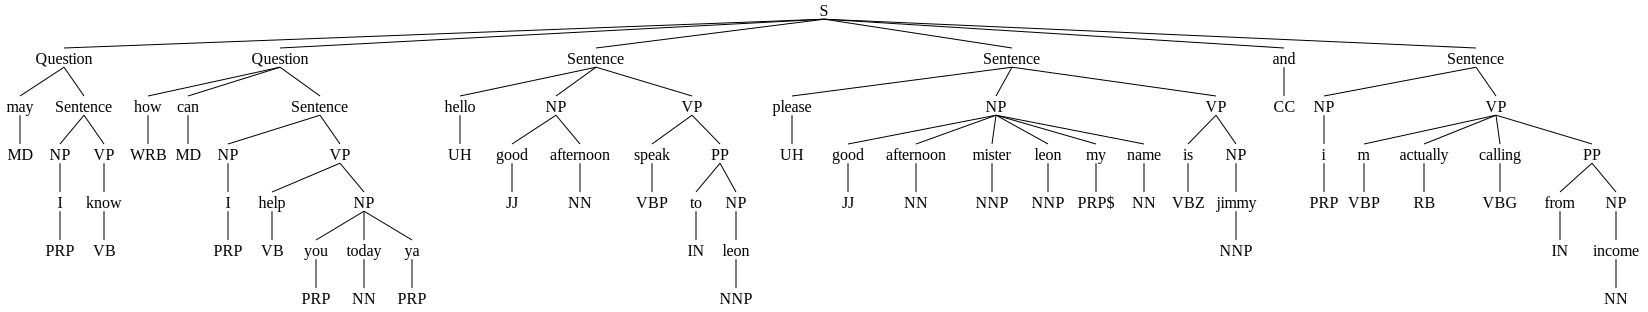

In [185]:
# grammar rules collections

# NP: noun phrases
# PP: preposition phrases
# VP: verb phrases
# 
grammar = r""" 
    NP: {<PRP.*|DT|JJ|NN.*>+}
    PP: {<IN|TO|RP><NP|VB.*>} 
    VP: {<VB.*|RB.*>+<PP|NP>*}
    Sentence: {<UH>*<NP>+<MD>*<VP|PP|NP>+}
    Sentence: {<PP|VP|NP>+}
    Question: {<MD|WDT|DP|WRB|><MD>*<Sentence|NP|PP|VP>}
    
    
"""
chunkParser = nltk.RegexpParser(grammar)
chunked = chunkParser.parse(pos_ls)
print(chunked)
chunked

In [186]:
# Loop through the parse tree and extract useful sentences/questions
# This function can only works for Sentence/Question label
def run_traverse(t):
    new_sens = []
    def traverse(t, ls = []):
        try:
            if (t.label() == 'Sentence' or t.label() == "Question") and ls:
                new_sens.append(ls)
                ls = []
        except AttributeError:
            ls.append(t[0])
        else:
            for child in t:
                ls = traverse(child, ls)

        return ls
    ls = traverse(t)
    new_sens.append(ls)
    return new_sens

In [187]:
new_sens = run_traverse(chunked)

In [188]:
new_sens

[['may'],
 ['I', 'know'],
 ['how', 'can'],
 ['I', 'help', 'you', 'today', 'ya'],
 ['hello', 'good', 'afternoon', 'speak', 'to', 'leon'],
 ['please',
  'good',
  'afternoon',
  'mister',
  'leon',
  'my',
  'name',
  'is',
  'jimmy',
  'and'],
 ['i', 'm', 'actually', 'calling', 'from', 'income']]

In [189]:
# Try to set up the function can work for any label in the level 1
def run_traverse2(t):
    new_sens = []
    def traverse(t, level = 0, ls = []):
        try:
            if t.label() and level == 1 and ls:
                new_sens.append(ls)
                ls = []
        except AttributeError:
            ls.append(t[0])
        else:
            for i, child in enumerate(t):
                if i == 0:
                    level += 1
                ls = traverse(child, level, ls)
                if i == len(t)-1:
                    level -= 1
        return ls
    ls = traverse(t)
    new_sens.append(ls)
    return new_sens

In [190]:
new_sens2 = run_traverse2(chunked)

In [191]:
new_sens2

[['may', 'I', 'know'],
 ['how', 'can', 'I', 'help', 'you', 'today', 'ya'],
 ['hello', 'good', 'afternoon', 'speak', 'to', 'leon'],
 ['please',
  'good',
  'afternoon',
  'mister',
  'leon',
  'my',
  'name',
  'is',
  'jimmy',
  'and'],
 ['i', 'm', 'actually', 'calling', 'from', 'income']]

In [192]:
# Add label to the return result, e.g. sentence/question
def run_traverse3(t):
    new_sens = []
    labels = []
    level = 0
    def traverse(t, level = 0, ls = []):
        try:
            if t.label() and level == 1 and ls:
                new_sens.append(ls)
                ls = []
            if t.label() and level == 1:
                labels.append(t.label())
        except AttributeError:
            ls.append(t[0])
        else:
            for i, child in enumerate(t):
                if i == 0:
                    level += 1
                ls = traverse(child, level, ls)
                if i == len(t)-1:
                    level -= 1
        return ls
    ls = traverse(t, level)
    new_sens.append(ls)
    return new_sens, labels

In [193]:
new_sens3 = run_traverse3(chunked)

In [194]:
len(new_sens3[1])

5

In [195]:
# Group each label with each sentence as a tuple, and group sentences with less 5 words with the next sentence together
# input example(sentences, labels)
# sen_return_type can be either "list" or "string"
def cluster_part(parts, cluster_threshold = 5, sen_return_type = "string"):
    sen_return_type = sen_return_type.lower()
    if sen_return_type != "string" and sen_return_type != "list":
        raise Exception(f"Current return type {sen_return_type} is not supported.")
    new_sen = []
    temp_sen = []
    # If false, means we won't store current sentence to the temporary list, Otherwise, store the current sentence
    # and insert to the front of the next sentence
    activated = False
    for sentence, label in zip(parts[0], parts[1]):
        if len(sentence) < cluster_threshold and len(temp_sen) < cluster_threshold:
            activated = True
            temp_sen.extend(sentence)
            continue
        else:
            activated = False
            if temp_sen:
                sentence = temp_sen + sentence
                temp_sen = []
            if sen_return_type == "string":
                sentence = " ".join([i for i in sentence])
            new_sen.append((label, sentence))       
    return new_sen
cluster_part(new_sens3, 5, "String")

[('Question', 'may I know how can I help you today ya'),
 ('Sentence', 'hello good afternoon speak to leon'),
 ('Sentence', 'please good afternoon mister leon my name is jimmy and'),
 ('Sentence', 'i m actually calling from income')]

In [196]:
for sentence in doc.sents:
    print(sentence)

ya hello good afternoon speak to nanny seah
please afternoon miss
nally
my name is jaafar same
and im actually calling from income ntuc income miss nally good time to speak for a while
this is regarding our partnership ocbc_plus members and as a result of that income actually formulated a very special fiftieth anniversay insurance bundle right called the i fifty


### Try long sentences

In [197]:
long_sen = "ya hello good afternoon speak to nanny seah please afternoon miss nally my name is jaafar same and im actually calling from income ntuc income miss nally good time to speak for a while this is regarding our partnership ocbc_plus members and as a result of that income actually formulated a very special fiftieth anniversay insurance bundle right called the i fifty "

In [198]:
doc = nlp(long_sen)

In [199]:
# Try sentisizer
for sentence in doc.sents:
    print(sentence)

ya hello good afternoon speak to nanny seah
please afternoon miss
nally
my name is jaafar same
and im actually calling from income ntuc income miss nally good time to speak for a while
this is regarding our partnership ocbc_plus members and as a result of that income actually formulated a very special fiftieth anniversay insurance bundle right called the i fifty


In [200]:
# Try customized grammar rule
pos_ls2 = []
for token in doc:
    pos_ls2.append((token.text, token.tag_))
print(pos_ls2)

[('ya', 'UH'), ('hello', 'UH'), ('good', 'JJ'), ('afternoon', 'NN'), ('speak', 'VBP'), ('to', 'IN'), ('nanny', 'NN'), ('seah', 'NNP'), ('please', 'UH'), ('afternoon', 'NN'), ('miss', 'NNP'), ('nally', 'NNP'), ('my', 'PRP$'), ('name', 'NN'), ('is', 'VBZ'), ('jaafar', 'NNP'), ('same', 'JJ'), ('and', 'CC'), ('i', 'PRP'), ('m', 'VBP'), ('actually', 'RB'), ('calling', 'VBG'), ('from', 'IN'), ('income', 'NN'), ('ntuc', 'NNP'), ('income', 'NNP'), ('miss', 'NNP'), ('nally', 'NNP'), ('good', 'JJ'), ('time', 'NN'), ('to', 'TO'), ('speak', 'VB'), ('for', 'IN'), ('a', 'DT'), ('while', 'NN'), ('this', 'DT'), ('is', 'VBZ'), ('regarding', 'VBG'), ('our', 'PRP$'), ('partnership', 'NN'), ('ocbc_plus', 'NN'), ('members', 'NNS'), ('and', 'CC'), ('as', 'IN'), ('a', 'DT'), ('result', 'NN'), ('of', 'IN'), ('that', 'DT'), ('income', 'NN'), ('actually', 'RB'), ('formulated', 'VBD'), ('a', 'DT'), ('very', 'RB'), ('special', 'JJ'), ('fiftieth', 'JJ'), ('anniversay', 'NN'), ('insurance', 'NN'), ('bundle', 'NN'),

(S
  (Sentence
    ya/UH
    hello/UH
    (NP good/JJ afternoon/NN)
    (VP speak/VBP (PP to/IN (NP nanny/NN seah/NNP))))
  (Sentence
    please/UH
    (NP afternoon/NN miss/NNP nally/NNP my/PRP$ name/NN)
    (VP is/VBZ (NP jaafar/NNP same/JJ)))
  and/CC
  (Sentence
    (NP i/PRP)
    (VP
      m/VBP
      actually/RB
      calling/VBG
      (PP
        from/IN
        (NP
          income/NN
          ntuc/NNP
          income/NNP
          miss/NNP
          nally/NNP
          good/JJ
          time/NN))
      (PP to/TO speak/VB)
      (PP for/IN (NP a/DT while/NN this/DT)))
    (VP
      is/VBZ
      regarding/VBG
      (NP our/PRP$ partnership/NN ocbc_plus/NN members/NNS)))
  and/CC
  (Sentence
    (PP as/IN (NP a/DT result/NN))
    (PP of/IN (NP that/DT income/NN))
    (VP actually/RB formulated/VBD (NP a/DT))
    (VP
      very/RB
      (NP
        special/JJ
        fiftieth/JJ
        anniversay/NN
        insurance/NN
        bundle/NN))
    (VP right/RB called/VBD (NP the/DT

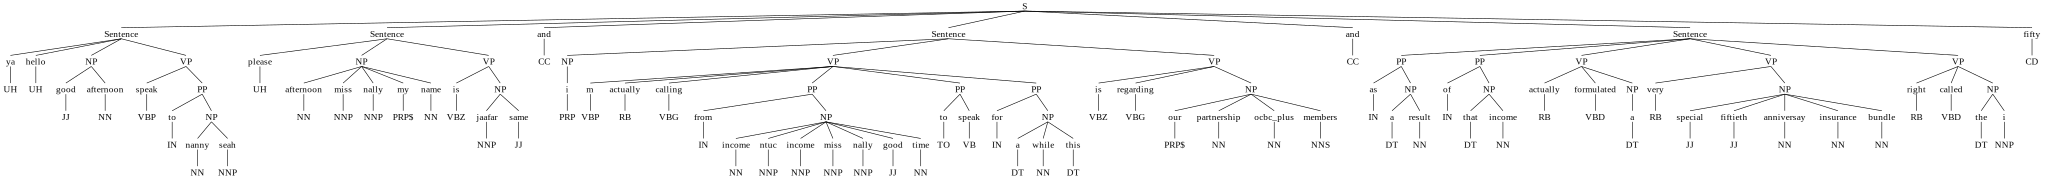

In [201]:
chunkParser = nltk.RegexpParser(grammar)
chunked = chunkParser.parse(pos_ls2)
print(chunked)
chunked

In [202]:
new_sens4 = run_traverse3(chunked)
cluster_part(new_sens4, 5, "String")

[('Sentence', 'ya hello good afternoon speak to nanny seah'),
 ('Sentence', 'please afternoon miss nally my name is jaafar same and'),
 ('Sentence',
  'i m actually calling from income ntuc income miss nally good time to speak for a while this is regarding our partnership ocbc_plus members and'),
 ('Sentence',
  'as a result of that income actually formulated a very special fiftieth anniversay insurance bundle right called the i fifty')]